# WGCNA

+ Author: Margaret Paiva
+ Date: 2021-12-11

In [21]:
suppressWarnings(require('pkgmaker',quietly = T))
require('plyr',quietly = T)
l_ply(c('dplyr',
        'data.table',
        'tidyr',  
        'tibble',
        'jsonlite', 
        'rjson',
        'httr',
        'WGCNA', 
        'cluster', 
        'ggplot2'), function(pkg) {
          invisible(capture.output(irequire(pkg, quiet = T, autoinstall = T)))
        })

In [2]:
allowWGCNAThreads()   
options(stringsAsFactors = FALSE)

Allowing multi-threading with up to 8 threads.


## Expression data

Uncomment the following code to download a set of data.

In [3]:
# # In "gene_list.csv", define a list of genes of interest
# gene_list  <- as.list(read.csv("gene_list.csv")$x)

# # Define the data to query from API
# data  <- list("request_data_type" = "expression",
#               # If only pathway enrichment analysis is needed, you may request only one cancer type
#               # to see what pathways are enriched for a specific cancer type
#   "request_cancer_type" = c("Renal cell carcinoma", "Prostate", "Adenoid cystic carcinoma", "Breast", 
#                             "Thyroid", "Testicular", "Hepatocellular carcinoma", "Melanoma"),
# #   "request_genes" = c("ATM", "BRCA1", "BRCA2", "BRIP1", "CDK12", "FANCA", "HDAC2", "KRAS", 
# #                       "PALB2", "SRY", "TP53", "NOTCH1", "CCND1", "BARD1", "FBLN2", "CDKN1B", 
# #                       "RB1", "CHEK2", "APOBEC3B", "PALB2"),  # to define a list of genes here
#   "request_genes" = gene_list,  # if a list of genes is defined in a file
#   "request_dataset" = "PDX",
#   "request_key" = "---",  # enter your token here
#   "request_client" = 99,
#   "request_user" = 1234,  # enter your user id here
#   "request_workspace_id" = "1234-99",  # enter your user id "XXXX-99"
#   "request_mode" = 'true')

# # Request data from API - this may take some time
# request  <-  POST(url = 'https://lumin-fast-api.championsoncology.com/WS', 
#                   body = data, encode = 'json')
# request
# # A successful request will give "Status: 200"

In [4]:
# # This will save the data file as a .json file in your root directory
# response <- content(request)
# response

In [5]:
# After downloading the data, use the following to read them in.
# Enter the file name of the .json file in your root directory below
lt  <-  fromJSON(file = "./data/requested_data---19-10-2021---20_44_20.json")

In [6]:
# Create a dataframe from the data
df  <- do.call(rbind, lapply(lt, rbind))
df  <- as.data.frame(df)
df$gene  <- as.character(df$gene)  # each column is a list - specify data type
df$model  <- as.character(df$model)
df$tumor_type  <- as.character(df$tumor_type)
df$log.tpm  <- as.numeric(df$log.tpm)
head(df, 2)
print(dim(df))

v1,gene_id,log.rsem.rpkm,log.tpm,z,fold,trans,model,sort_key,gene,model_name,tumor_type
19463231,ENSG00000005187,2.03154538924124,2.7411490,-0.169317194943646,0.876569685689051,ENST00000440284:49.26% ENST00000567387:17.78% ENST00000501740:11.52% ENST00000289416:10.09%,CTG-3501,CTG-3501_Expression_1,ACSM3,CTG-3501,Breast
19463234,ENSG00000005243,0.43494348437293,0.7995996,-0.994615041230675,0.185174375597962,ENST00000006101:78.76% ENST00000579263:20.8%,CTG-3501,CTG-3501_Expression_1,COPZ2,CTG-3501,Breast


[1] 82800    12


In [7]:
# Pivot the table
log_tpm <- df %>% 
    select(c('gene', 'model', 'log.tpm'))  %>% 
    pivot_wider(names_from = gene, values_from = log.tpm)  %>% 
    column_to_rownames('model')
log_tpm  <- log_tpm[complete.cases(log_tpm),]  # remove rows with missing values
log_tpm[1:2, 1:10]
print(dim(log_tpm))

,ACSM3,COPZ2,BZRAP1,CX3CL1,ETV1,ALDH3B1,ACPP,CHDH,CD74,FHL1
CTG-3501,2.741149,0.7995996,2.833298,4.224392,0.9328516,1.441369,2.463359,3.7351793,2.288166,0.9457198
CTG-0718,3.214430,4.1304615,2.401043,1.547657,3.9235433,2.984612,0.000000,0.4733435,5.082362,3.4499709


[1] 207 400


## Select power

In [8]:
# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to = 20, by = 2))

# Call the network topology analysis function
sft = pickSoftThreshold(
  log_tpm,             # <= Input data
  powerVector = powers,
  verbose = 5
  )

pickSoftThreshold: will use block size 400.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 400 of 400
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0276 -0.329         0.9470 67.7000  6.40e+01 122.00
2      2   0.5900 -1.140         0.9020 18.3000  1.54e+01  52.30
3      3   0.8710 -1.450         0.9270  6.3900  4.50e+00  26.90
4      4   0.2140 -2.930         0.0112  2.6500  1.57e+00  15.70
5      5   0.8950 -1.570         0.8700  1.2500  5.99e-01  10.00
6      6   0.9080 -1.520         0.8840  0.6610  2.40e-01   6.78
7      7   0.8970 -1.470         0.8670  0.3810  9.81e-02   4.82
8      8   0.2350 -2.270         0.0362  0.2370  4.39e-02   3.55
9      9   0.2350 -2.180         0.0450  0.1570  2.03e-02   2.69
10    10   0.2350 -2.060         0.0487  0.1100  9.13e-03   2.08
11    12   0.1970 -1.770        -0.0327  0.0615  1.98e-03   1.31
12    14   0.9700 -1.080         0.9850  0.0393  4.99e-04   1.00
13 

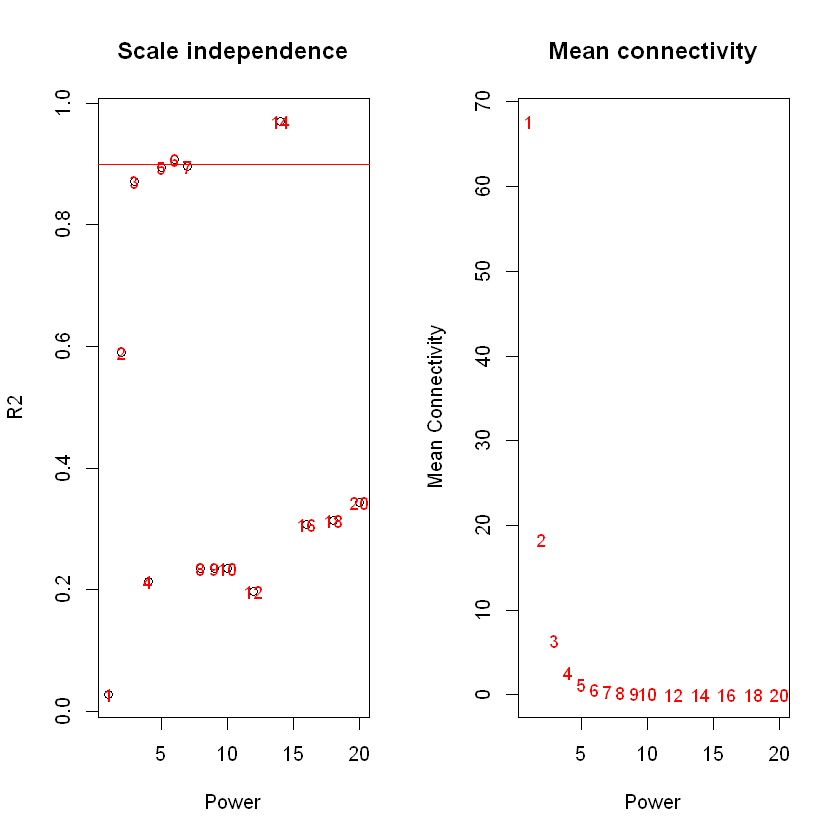

In [9]:
par(mfrow = c(1,2));
cex1 = 0.9;

plot(sft$fitIndices[, 1],
     -sign(sft$fitIndices[, 3]) * sft$fitIndices[, 2],
     xlab = "Power",
     ylab = "R2",
     main = paste("Scale independence")
)
text(sft$fitIndices[, 1],
     -sign(sft$fitIndices[, 3]) * sft$fitIndices[, 2],
     labels = powers, cex = cex1, col = "red"
)
abline(h = 0.90, col = "red")
plot(sft$fitIndices[, 1],
     sft$fitIndices[, 5],
     xlab = "Power",
     ylab = "Mean Connectivity",
     type = "n",
     main = paste("Mean connectivity")
)
text(sft$fitIndices[, 1],
     sft$fitIndices[, 5],
     labels = powers,
     cex = cex1, col = "red")

According to the above two plots, we should pick power=14.

## Create the network

In [10]:
picked_power = 9
temp_cor <- cor       
cor <- WGCNA::cor         # Force it to use WGCNA cor function (fix a namespace conflict issue)
netwk <- blockwiseModules(log_tpm,                # <= input here

                          # == Adjacency Function ==
                          power = picked_power,                # <= power here
                          networkType = "signed",

                          # == Tree and Block Options ==
                          deepSplit = 2,
                          pamRespectsDendro = F,
                          minModuleSize = 30,
                          maxBlockSize = 4000,

                          # == Module Adjustments ==
                          reassignThreshold = 0,
                          mergeCutHeight = 0.25,

                          # == Archive the run results in TOM file (saves time) == 
                          saveTOMs = T,
                          saveTOMFileBase = "ER",

                          # == Output Options
                          numericLabels = T,
                          verbose = 3)
cor <- temp_cor     # Return cor function to original namespace

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file ER-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 81 genes from module 1 because their KME is too low.
     ..removing 53 genes from module 2 because their KME is too low.
 ..merging modules that are too close..
     mergeCloseModules: Merging modules whose distance is less than 0.25
       Calculating new MEs...


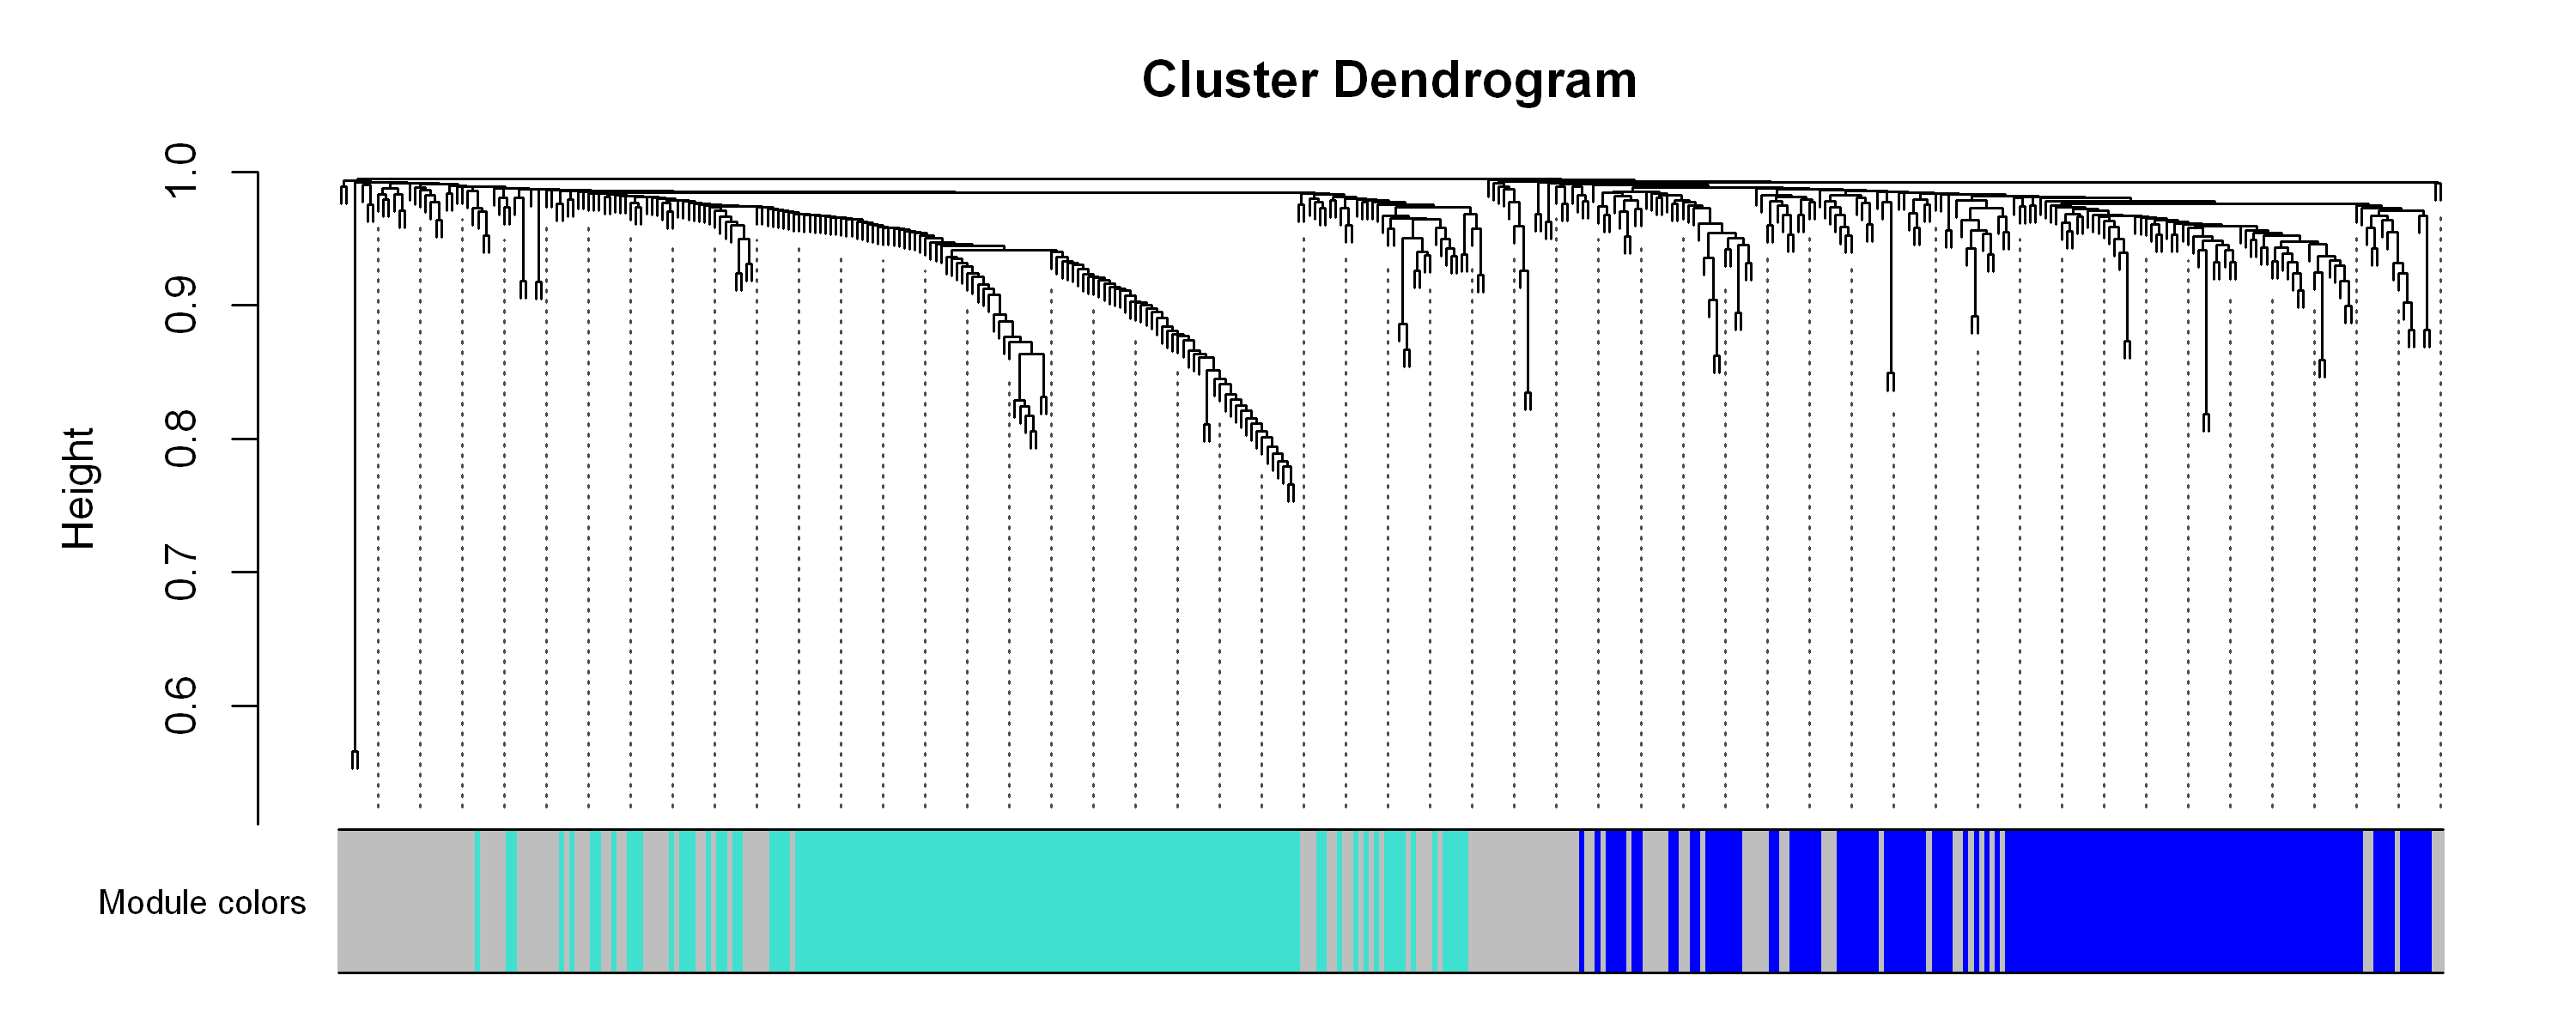

In [16]:
# Convert labels to colors for plotting
mergedColors = labels2colors(netwk$colors)
# Plot the dendrogram and the module colors underneath
options(repr.plot.width=10, repr.plot.height=4, repr.plot.res=300)
plotDendroAndColors(
  netwk$dendrograms[[1]],
  mergedColors[netwk$blockGenes[[1]]],
  "Module colors",
  dendroLabels = FALSE,
  hang = 0.03,
  addGuide = TRUE,
  guideHang = 0.05 )

## Relate modules

In [12]:
module_df <- data.frame(
  gene_id = names(netwk$colors),
  colors = labels2colors(netwk$colors)
)

In [24]:
head(module_df)

gene_id,colors
ACSM3,grey
COPZ2,blue
BZRAP1,turquoise
CX3CL1,blue
ETV1,blue
ALDH3B1,blue


In [13]:
# write_delim(module_df,
#             file = "./data/gene_modules.txt",
#             delim = "\t")

In [18]:
# Get Module Eigengenes per cluster
MEs0 <- moduleEigengenes(log_tpm, mergedColors)$eigengenes

# Reorder modules so similar modules are next to each other
MEs0 <- orderMEs(MEs0)
module_order <- names(MEs0) %>% gsub("ME","", .)

# Add model names
MEs0$model = row.names(MEs0)

head(MEs0, 2)

,MEblue,MEturquoise,MEgrey,model
CTG-3501,0.02297127,0.0122722,-0.01877377,CTG-3501
CTG-0718,0.07528201,-0.1044428,-0.04016629,CTG-0718


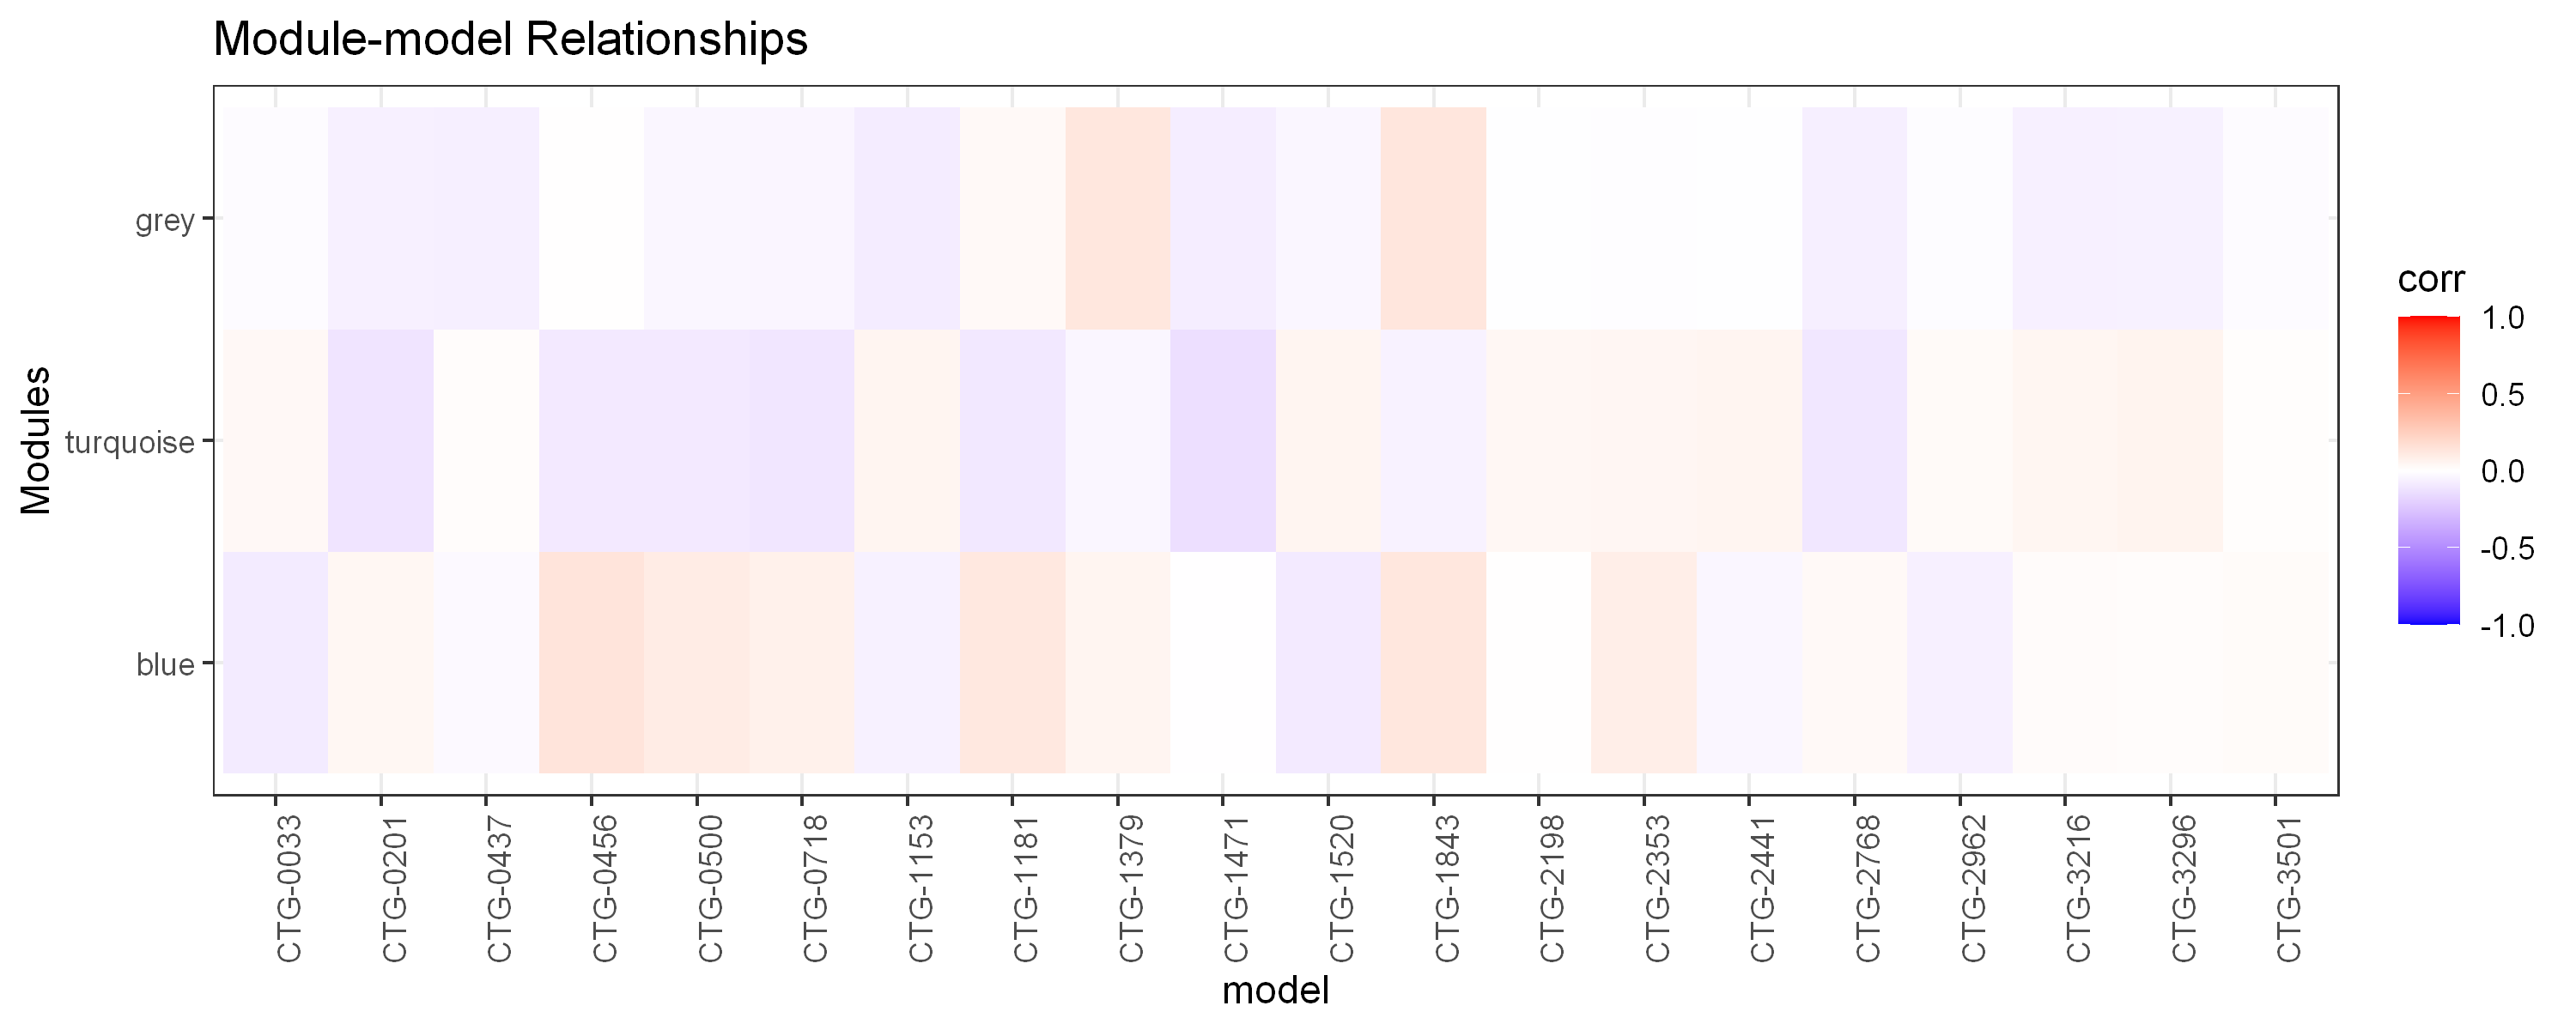

In [23]:
# tidy & plot data
mME = MEs0[1: 20,] %>%  # choose the first 20 models here - you may select models of interest
  pivot_longer(-model) %>%
  mutate(
    name = gsub("ME", "", name),
    name = factor(name, levels = module_order)
  )

mME %>% ggplot(., aes(x=model, y=name, fill=value)) +
  geom_tile() +
  theme_bw() +
  scale_fill_gradient2(
    low = "blue",
    high = "red",
    mid = "white",
    midpoint = 0,
    limit = c(-1,1)) +
  theme(axis.text.x = element_text(angle=90)) +
